In [1]:
import os, folium
import pandas as pd
import numpy as np

from shapely.geometry import Point, mapping
from fiona import collection

In [2]:
import geopandas

In [3]:
%load_ext autoreload
%autoreload 2

I have a csv file of lightning strikes for several years in New Zealand.
I will store this data as a:
<ul><li>ShapeFile</li> 
    <li>GeoPandasDF</li> 
    <li>DBF</li>
</ul>

## ShapeFile first

In [4]:
%%time
z = open("/media/thistle/Passport/gis/nz/lightning/mfe-lightning-strikes-20012016-CSV/lightning-strikes-20012016.csv")
cols = z.readline()
lines = z.readlines()

CPU times: user 376 ms, sys: 206 ms, total: 583 ms
Wall time: 2.51 s


In [5]:
z.close()
print(cols)
print(lines[0])

﻿lon,lat,year,month

177.275,-35.5582,2000,8



In [6]:
%%time
lines_striped = (line.strip() for line in lines) # removeing /n
# below-the data as strings
lines_split = (line.split(",") for line in lines_striped)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.39 µs


In [7]:
%%time
out_dir = "/home/thistle/Desktop/"
out_name = "lightning_nz.shp"
fp = out_dir + out_name
schema = {"geometry": "Point","properties":{"month":"int", "year":"int"}}

with collection(fp, "w", "ESRI Shapefile", schema) as output:
    for row in lines_split:
        point = Point(float(row[1]), float(row[0])) # (lat, lon)
        output.write({
            'properties': {      
                "month": row[3],
                "year": row[2]
            },
            "geometry": mapping(point)
        })
        

CPU times: user 2min 45s, sys: 14.6 s, total: 3min
Wall time: 3min


In [8]:
!fio info --indent 2 /home/thistle/Desktop/lightning_nz.shp

{
  "driver": "ESRI Shapefile",
  "schema": {
    "properties": {
      "month": "int:18",
      "year": "int:18"
    },
    "geometry": "Point"
  },
  "crs": "",
  "crs_wkt": "",
  "bounds": [
    -51.533,
    -180.0,
    -29.4402,
    179.9999
  ],
  "name": "lightning_nz",
  "count": 2903389
}


## now make a geodataframe
<ul style="font-size:20px; color:red;">either from a </ul>
  <li>dataframe creating a geometry column from lat and lon</li>
  <li>directly from the shapefile just created above</li>
</ul>

In [9]:
%%time
file_in = "/media/thistle/Passport/gis/nz/lightning/mfe-lightning-strikes-20012016-CSV/lightning-strikes-20012016.csv"
dtypes = [("lat", "float"), ("lon", "float"), ("year", "int"), ("month","int8")]

df = pd.read_csv(file_in, dtype=dtypes)

CPU times: user 557 ms, sys: 51.5 ms, total: 608 ms
Wall time: 610 ms


In [10]:
print(df.shape)
print(df.dtypes)
df.head()

(2903389, 4)
lon      float64
lat      float64
year       int64
month       int8
dtype: object


,lon,lat,year,month
0,177.2750,-35.5582,2000,8
1,177.0922,-35.5696,2000,8
2,177.9768,-33.7629,2000,8
3,177.3294,-33.9202,2000,8
4,177.1735,-35.9420,2000,8


In [11]:
#!conda list

In [12]:
%%time
gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.lon, df.lat))
gdf.head()

CPU times: user 20.7 s, sys: 280 ms, total: 21 s
Wall time: 21 s


,lon,lat,year,month,geometry
0,177.2750,-35.5582,2000,8,POINT (177.27500 -35.55820)
1,177.0922,-35.5696,2000,8,POINT (177.09220 -35.56960)
2,177.9768,-33.7629,2000,8,POINT (177.97680 -33.76290)
3,177.3294,-33.9202,2000,8,POINT (177.32940 -33.92020)
4,177.1735,-35.9420,2000,8,POINT (177.17350 -35.94200)


In [13]:
low_res = geopandas.datasets.get_path("naturalearth_lowres")
world = geopandas.read_file(low_res)

In [14]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


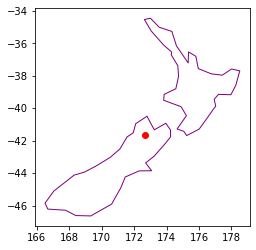

In [18]:
nz = world[world.name == "New Zealand"]
nzp = nz.plot(color='white', edgecolor="purple")


#nz.geom_type
c = nz.centroid

c.plot(ax=nzp, color='red')

In [19]:
nz

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
136,4510327,Oceania,New Zealand,NZL,174800.0,"MULTIPOLYGON (((176.88582 -40.06598, 176.50802..."


In [20]:
nz.bounds

,minx,miny,maxx,maxy
136,166.509144,-46.641235,178.517094,-34.450662


In [23]:
nz.area

136    30.060977
dtype: float64

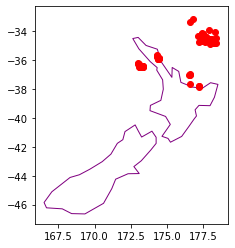

In [28]:
nzp = nz.plot(color='white', edgecolor="purple")

a = gdf[100000:100111].plot(ax=nzp, color="red")


In [47]:
import fiona

In [48]:
fiona.supported_drivers

{'AeronavFAA': 'r',
 'ARCGEN': 'r',
 'BNA': 'raw',
 'DXF': 'raw',
 'CSV': 'raw',
 'OpenFileGDB': 'r',
 'ESRIJSON': 'r',
 'ESRI Shapefile': 'raw',
 'GeoJSON': 'rw',
 'GeoJSONSeq': 'rw',
 'GPKG': 'rw',
 'GML': 'raw',
 'GPX': 'raw',
 'GPSTrackMaker': 'raw',
 'Idrisi': 'r',
 'MapInfo File': 'raw',
 'DGN': 'raw',
 'PCIDSK': 'r',
 'S57': 'r',
 'SEGY': 'r',
 'SUA': 'r',
 'TopoJSON': 'r'}

In [39]:
df.shape

(2903389, 5)

In [41]:
z = slice(10,20)

In [43]:
a = list(range(10,100,2))

In [45]:
a[z]

[30, 32, 34, 36, 38, 40, 42, 44, 46, 48]

In [33]:
df['coordinates'] = str(df['lat'])

In [26]:
#df['coordinates'] = df['lon'] * 3

In [32]:
df.coordinates.head()

0    0         -35.5582\n1         -35.5696\n2     ...
1    0         -35.5582\n1         -35.5696\n2     ...
2    0         -35.5582\n1         -35.5696\n2     ...
3    0         -35.5582\n1         -35.5696\n2     ...
4    0         -35.5582\n1         -35.5696\n2     ...
Name: coordinates, dtype: object

In [29]:
a = pd.Series((df['lat'], df['lon']))

In [30]:
a

0    0         -35.5582
1         -35.5696
2       ...
1    0          177.2750
1          177.0922
2     ...
dtype: object

In [ ]:
def mark_a_row(row):
    folium.CircleMarker(location=[row["latitude"], row["longitude"]], radius=1, fill=True, color="yellow", popup=f"{convert_to_months(int(row['month']))}, {int(row['year'])}:\nlat:{row['latitude']}\nlon:{row['longitude']}").add_to(mymap)

In [ ]:
%%time
dfff = dff.apply(mark_a_row, axis = 1)